## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams.

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

### Q1.

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [3]:
import pickle
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens.

What do you notice about the frequency of occurrence of different tokens? How does it look?

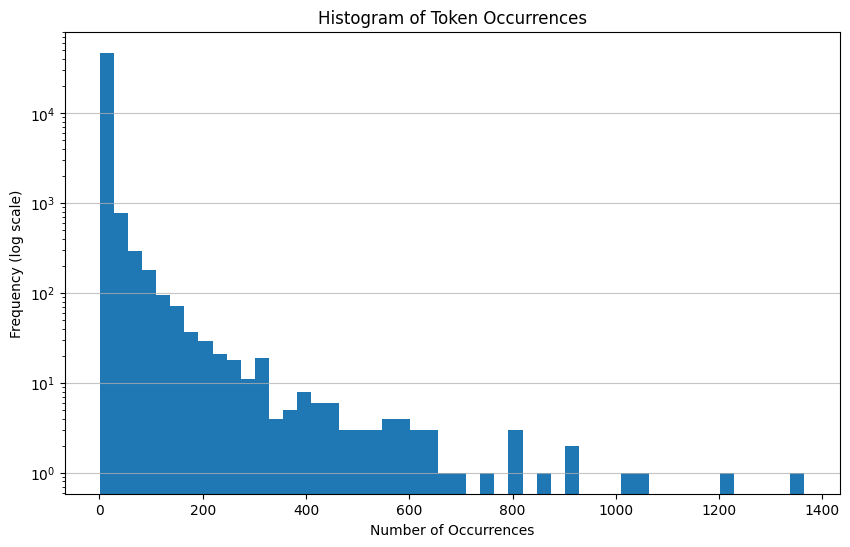

In [4]:
import matplotlib.pyplot as plt

counts = [count for token, count in token_freq]

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=50, log=True) # Using log scale on y-axis for better visualization of skewed data
plt.title('Histogram of Token Occurrences')
plt.xlabel('Number of Occurrences')
plt.ylabel('Frequency (log scale)')
plt.grid(axis='y', alpha=0.75)
plt.show()

#The highest frequency of token occurrences is at zero, and the histogram is right-skewed with high outliers

### Q2.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

phish = pd.read_parquet('Phishing_clean.parquet')
# phish.head() # Commenting out head() as it's not needed for the analysis

# Separate features (X) and target (y)
X = phish.drop('Email Type', axis=1)
y = phish['Email Type']

# Part 1
# Perform 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Part 2
# Run a linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate R-squared on training and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'R-squared on training set: {r2_train:.4f}')
print(f'R-squared on test set: {r2_test:.4f}')

# Part 3
# Get coefficients and corresponding token names
coefficients = model.coef_
tokens = X.columns

# Create a DataFrame of coefficients and tokens
coef_df = pd.DataFrame({'Token': tokens, 'Coefficient': coefficients})

# Get the absolute value of coefficients and sort to find the largest
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
most_influential_words = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(10)

print("\nWords with largest absolute coefficients:")
display(most_influential_words[['Token', 'Coefficient']])

R-squared on training set: 0.7670
R-squared on test set: 0.6659

Words with largest absolute coefficients:


,Token,Coefficient
835,intervention,-1.259257
740,localized,0.824350
2362,thermal,0.747006
851,crawler,0.696167
1504,background-image:,-0.622909
1406,"helvetica,",0.598560
906,aging,0.594956
1839,form.,0.576886
2242,gray;,-0.574480
1552,a:active,0.574480


### Q3.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

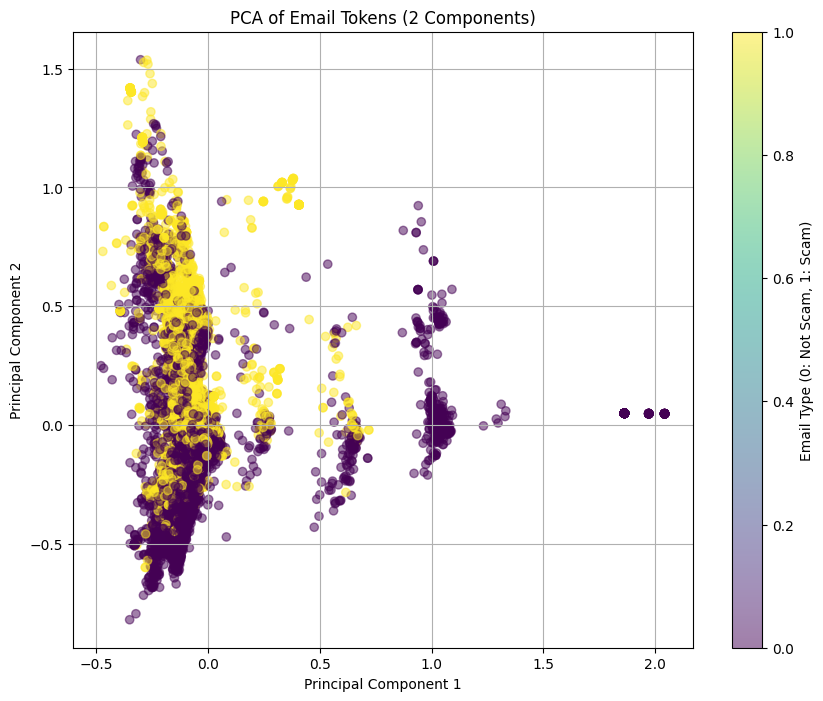

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame for the principal components and email type
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Email Type'] = y.values # Add the target variable for coloring

# Plot the first two principal components
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Email Type'], cmap='viridis', alpha=0.5)
plt.title('PCA of Email Tokens (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Email Type (0: Not Scam, 1: Scam)')
plt.grid(True)
plt.show()

#The purple (non-scam emails) have a larger variety in the principal component 1 (they go all the way up to 2.0 but scam emails only go to a little above 0.5)
#The yellow (scam emails) are more clustered around the lower PC1 values, but they have a large variation in the PC2 values

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [8]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd

# Perform PCA with 2610 components
pca_2610 = PCA(n_components=2610)
X_pca_2610 = pca_2610.fit_transform(X) # Using X from previous cells

# Split the PCA transformed data
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca_2610, y, test_size=0.2, random_state=42) # Using y from previous cells

# Run a linear regression on the PCA transformed data
model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train)

# Predict on training and test sets
y_train_pred_pca = model_pca.predict(X_train_pca)
y_test_pred_pca = model_pca.predict(X_test_pca)

# Calculate R-squared on training and test sets
r2_train_pca = r2_score(y_train, y_train_pred_pca)
r2_test_pca = r2_score(y_test, y_test_pred_pca)

print(f'R-squared on training set with PCA: {r2_train_pca:.4f}')
print(f'R-squared on test set with PCA: {r2_test_pca:.4f}')

# The performance values are quite similar between the two


R-squared on training set with PCA: 0.7662
R-squared on test set with PCA: 0.6684


### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Using principal components (PCs) offers many advantages over using the original data:

-   **Dimensionality Reduction:** PCA reduces the number of features while retaining most of the important information.
-   **Multicollinearity:** In the original data, many tokens might be highly correlated. PCs are uncorrelated, which eliminates multicollinearity in the regression.
-   **Noise Reduction:** Principal components can capture the underlying variance in the data and effectively reduce noise in the data.
-   **Improved Generalization:** Reducing the number of features and addressing multicollinearity can help prevent overfitting.